In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [7]:
class LinearRegressionNeuron:
    """
    A single neuron model for linear regression.  This is a simplified neural network.

    Attributes:
        learning_rate (float): The learning rate for weight updates.
        n_iters (int): The number of iterations for training.
        weights (ndarray): The weights of the neuron.
        bias (float): The bias term of the neuron.
    """
    def __init__(self, learning_rate=0.01, n_iters=1000):
        """
        Initializes the LinearRegressionNeuron.

        Args:
            learning_rate (float, optional): The learning rate. Defaults to 0.01.
            n_iters (int, optional): The number of iterations. Defaults to 1000.
        """
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        """
        Trains the neuron on the given data using gradient descent.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).
            y (ndarray): The target values, shape (n_samples,).
        """
        n_samples, n_features = X.shape

        # Initialize weights and bias to zeros
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Run gradient descent for the specified number of iterations
        for _ in range(self.n_iters):
            # Calculate predictions
            y_predicted = np.dot(X, self.weights) + self.bias

            # Calculate the prediction error
            error = y_predicted - y

            # Calculate gradients of loss with respect to weights and bias
            dw = (1 / n_samples) * np.dot(X.T, error)  # Gradient of weights
            db = (1 / n_samples) * np.sum(error)      # Gradient of bias

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        """
        Predicts the output for the given data.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).

        Returns:
            ndarray: The predicted values, shape (n_samples,).
        """
        return np.dot(X, self.weights) + self.bias
    
    def score(self, X, y):
        """
        Calculates the coefficient of determination (R^2) of the prediction.

        Args:
            X (ndarray): Input features, shape (n_samples, n_features).
            y (ndarray): True target values, shape (n_samples,).

        Returns:
            float: R^2 score.
        """
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        return 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

In [17]:
df = pd.read_csv("cleaned_mlb_2022_full.csv")
df = df[df['PA'] >= 200]  # Only consider hitters with at least 200 PA

# Select features and target
features = ['HR', 'BB', 'AVG', 'OPS', 'RBI']
target = 'WAR'

X = df[features].values
y = df[target].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [19]:
neuron = LinearRegressionNeuron(learning_rate=0.01, n_iters=1000)
neuron.fit(X_train, y_train)

# Predict
train_preds = neuron.predict(X_train)
test_preds = neuron.predict(X_test)

# R² scores
train_r2 = neuron.score(X_train, y_train)
test_r2 = neuron.score(X_test, y_test)

print(f"Train R² Score: {train_r2:.2f}")
print(f"Test R² Score: {test_r2:.2f}")

Train R² Score: 0.60
Test R² Score: 0.63


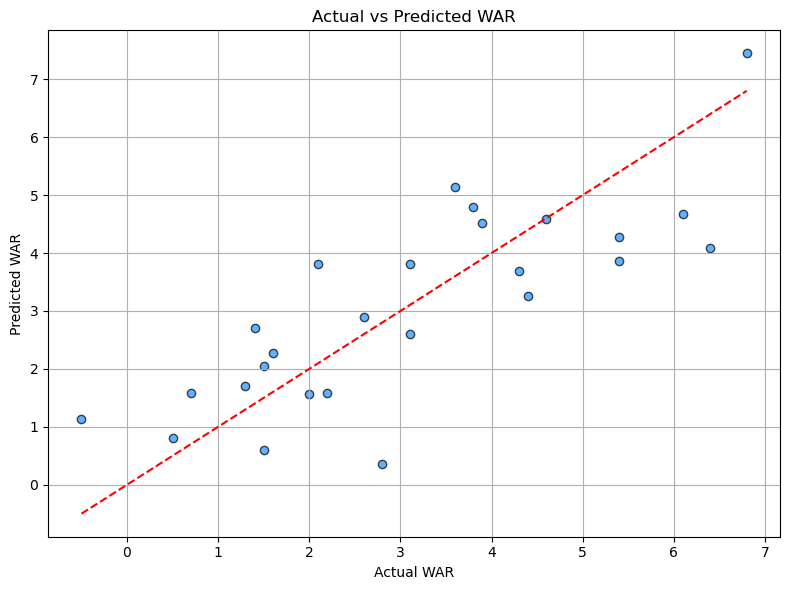

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_preds, alpha=0.7, edgecolor='k', color='dodgerblue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual WAR")
plt.ylabel("Predicted WAR")
plt.title("Actual vs Predicted WAR")
plt.grid(True)
plt.tight_layout()
plt.show()

This plot gives us a visualization of the quality of predictions. Ideally, points should lie close to the red diagonal line. While the model performs reasonably well on most mid-range and lower WAR values, it struggles to capture the true variance in players with very high WAR. This could suggest limited model capacity or nonlinearities that aren't captured by a single neuron.

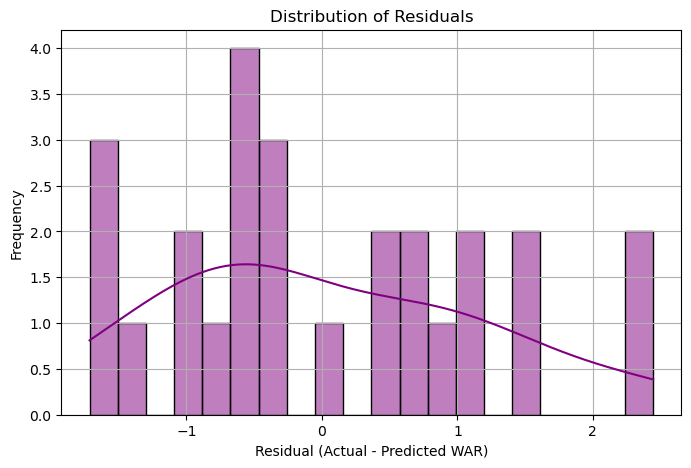

In [27]:
residuals = y_test - test_preds

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color='purple', bins=20)
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted WAR)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

This histogram shows the distribution of residuals, which gives us insight into how well the linear regression model is capturing the data. In this case, the residuals appear to be approximately symmetric and centered around zero, which supports one of the key assumptions of linear regression: that errors are normally distributed. Although the distribution is slightly right-skewed and not perfectly normal, it doesn’t raise major concerns about bias or structural issues in the model. The residuals are reasonably concentrated near zero with no major outliers, indicating a decent model fit overall.

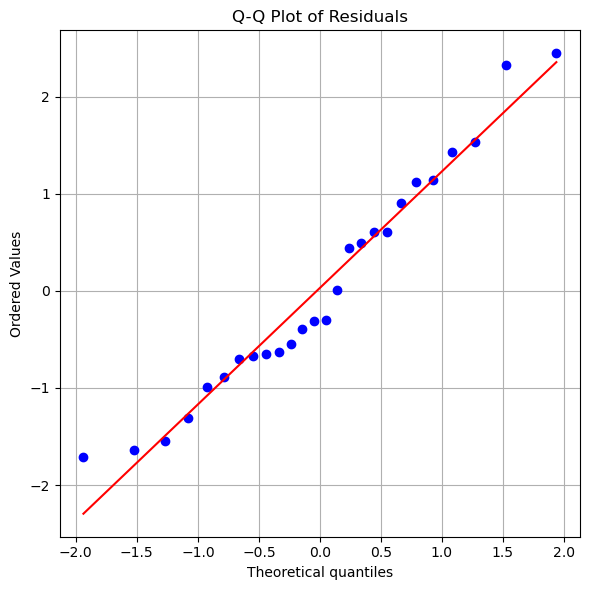

In [29]:
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

The Q-Q plot compares the distribution of the residuals to a theoretical normal distribution. In a well-behaved linear regression model, the residuals should fall approximately along the red reference line. In this case, the plot shows that most residuals lie close to the line, with only minor deviations at the tails. This suggests that the residuals are reasonably normally distributed, reinforcing what we observed in the histogram earlier.

While it’s not a perfect match, the alignment is strong enough to support the assumption of normality, especially for a relatively small dataset. This gives us further confidence that the linear regression model is not systematically biased and that inference methods relying on normality (like confidence intervals or hypothesis tests) would be reasonably valid.

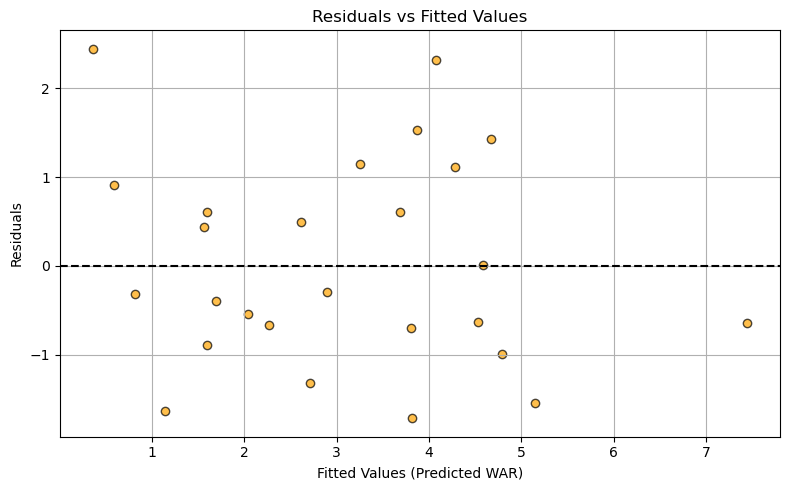

In [31]:
plt.figure(figsize=(8, 5))
plt.scatter(test_preds, residuals, alpha=0.7, edgecolor='k', color='orange')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel("Fitted Values (Predicted WAR)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.grid(True)
plt.tight_layout()
plt.show()

This plot helps assess whether the residuals exhibit homoscedasticity, or constant variance across all levels of predicted values — an important assumption in linear regression. In this case, the residuals appear to be randomly scattered around the horizontal axis with no obvious patterns or trends. That’s a good sign — it suggests that the model’s errors are roughly equally distributed across all levels of predicted WAR. There’s no strong evidence of nonlinearity or heteroscedasticity here, which supports the use of a linear model in this context.